<a href="https://colab.research.google.com/github/yashpatil454/Deep_Audio_Classifier_Convolutinal_NN/blob/main/Deep_Audio_Classifier_Convolutional_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yashpatil454","key":"e4f700df75f92a9ab4281ff6cbc9a747"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

 98% 594M/604M [00:06<00:00, 117MB/s] 
100% 604M/604M [00:06<00:00, 102MB/s]


In [4]:
!unzip /content/z-by-hp-unlocked-challenge-3-signal-processing.zip

Archive:  /content/z-by-hp-unlocked-challenge-3-signal-processing.zip
  inflating: Forest Recordings/recording_00.mp3  
  inflating: Forest Recordings/recording_01.mp3  
  inflating: Forest Recordings/recording_02.mp3  
  inflating: Forest Recordings/recording_03.mp3  
  inflating: Forest Recordings/recording_04.mp3  
  inflating: Forest Recordings/recording_05.mp3  
  inflating: Forest Recordings/recording_06.mp3  
  inflating: Forest Recordings/recording_07.mp3  
  inflating: Forest Recordings/recording_08.mp3  
  inflating: Forest Recordings/recording_09.mp3  
  inflating: Forest Recordings/recording_10.mp3  
  inflating: Forest Recordings/recording_11.mp3  
  inflating: Forest Recordings/recording_12.mp3  
  inflating: Forest Recordings/recording_13.mp3  
  inflating: Forest Recordings/recording_14.mp3  
  inflating: Forest Recordings/recording_15.mp3  
  inflating: Forest Recordings/recording_16.mp3  
  inflating: Forest Recordings/recording_17.mp3  
  inflating: Forest Recordings

In [20]:
!pip install tensorflow-io
import os
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Data loading and Preprocessing of the audio function

In [59]:
CAPUCHIN_FILE = os.path.join('Parsed_Capuchinbird_Clips', 'XC3776-6.wav')
NOT_CAPUCHIN_FILE = os.path.join('Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-10.wav')

In [46]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [60]:
load_wav_16k_mono(CAPUCHIN_FILE)

<tf.Tensor: shape=(64000,), dtype=float32, numpy=
array([-3.3910814e-07,  1.0247953e-06, -1.3469314e-06, ...,
       -3.0875366e-02,  3.8422588e-02,  4.3280780e-02], dtype=float32)>

##Visualizing decode wav data

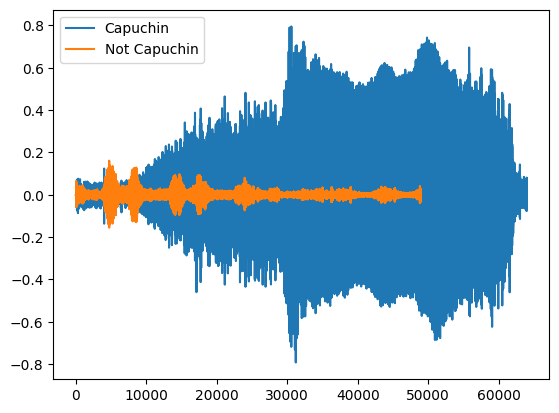

In [62]:
# Load and plot the first waveform
wav_capuchin = load_wav_16k_mono(CAPUCHIN_FILE)
plt.plot(wav_capuchin, label='Capuchin')

# Load and plot the second waveform
wav_not_capuchin = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
plt.plot(wav_not_capuchin, label='Not Capuchin')

# Add legend and show
plt.legend()
plt.show()

##Creating TF datasets and adding labels

In [71]:
pos = tf.data.Dataset.list_files(os.path.join('Parsed_Capuchinbird_Clips', '*.wav'))
neg = tf.data.Dataset.list_files(os.path.join('Parsed_Not_Capuchinbird_Clips', '*.wav'))

In [99]:
positives = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives).shuffle(1000)

In [111]:
time_duration = []
for file in os.listdir(os.path.join('Parsed_Capuchinbird_Clips')):
  tensor_wav = load_wav_16k_mono(os.path.join('Parsed_Capuchinbird_Clips', file))
  time_duration.append(round(len(tensor_wav)/16000,2))

In [112]:
print(time_duration)

[2.5, 3.5, 3.0, 3.0, 4.5, 3.0, 3.5, 5.0, 3.0, 4.0, 3.5, 2.5, 3.0, 3.0, 3.5, 3.5, 3.5, 4.0, 4.0, 3.0, 3.0, 4.0, 3.5, 3.0, 4.0, 3.5, 2.5, 3.5, 3.5, 3.5, 2.5, 3.5, 4.0, 3.0, 4.0, 3.5, 3.5, 3.0, 4.0, 3.0, 3.5, 3.5, 3.5, 3.5, 3.0, 3.5, 3.5, 3.0, 3.5, 4.0, 4.0, 3.5, 3.0, 4.0, 3.5, 3.5, 3.0, 3.5, 3.5, 3.5, 3.5, 3.0, 3.5, 3.0, 3.5, 3.5, 3.0, 3.5, 3.5, 4.5, 3.0, 3.5, 3.5, 2.5, 3.0, 3.0, 3.5, 3.0, 4.0, 3.0, 3.5, 3.5, 4.0, 3.5, 3.0, 3.5, 3.0, 2.5, 3.0, 3.0, 2.5, 3.0, 4.0, 3.0, 2.5, 3.5, 3.0, 3.5, 3.5, 4.0, 4.0, 3.5, 3.5, 4.0, 3.0, 3.0, 2.5, 3.0, 3.0, 3.0, 4.0, 3.0, 4.0, 2.5, 3.0, 3.0, 3.0, 4.5, 3.5, 4.0, 3.0, 3.5, 3.5, 4.0, 3.0, 3.5, 3.5, 4.0, 4.0, 2.0, 3.5, 4.0, 3.0, 4.5, 3.5, 4.5, 4.0, 3.0, 2.5, 3.5, 3.0, 4.0, 3.5, 3.5, 3.0, 3.5, 4.0, 4.0, 3.5, 3.5, 2.5, 3.5, 3.0, 4.0, 3.5, 4.0, 3.5, 3.5, 3.5, 3.0, 3.5, 3.5, 3.5, 4.0, 3.5, 4.0, 2.5, 3.0, 3.0, 3.5, 3.0, 4.0, 4.0, 3.5, 3.5, 3.5, 4.0, 3.5, 2.5, 2.5, 3.5, 3.5, 4.0, 4.0, 3.5, 3.5, 2.5, 2.5, 3.5, 3.0, 3.5, 3.5, 4.0, 3.5, 3.5, 4.0, 2.0, 3.0, 3.5, 3.5,

In [114]:
tf.math.reduce_mean(time_duration)

<tf.Tensor: shape=(), dtype=float32, numpy=3.3847926>

In [117]:
tf.math.reduce_min(time_duration)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [119]:
tf.math.reduce_max(time_duration)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>